In [1]:
# Jupyter magic
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library

# import the tdt library
import tdt
import pandas as pd

In [52]:
# Must read with "/" not "\
NAc_PATH = r'C:\Users\yongc\Desktop\Synapse\Tanks\RewardTrainingComp-240307-102847\dLight_NAc-240308-053210'
NAc_data = tdt.read_block(NAc_PATH)

Found Synapse note file: C:\Users\yongc\Desktop\Synapse\Tanks\RewardTrainingComp-240307-102847\dLight_NAc-240308-053210\Notes.txt
read from t=0s to t=1816.06s


In [53]:
NAc_data.info

tankpath:	'C:\\Users\\yongc\\Desktop\\Synapse\\Tanks\\RewardTrainingComp-240307-102847'
blockname:	'dLight_NAc-240308-053210'
start_date:	datetime.datetime(2024, 3, 8, 8, 32, 14, 999999)
utc_start_time:	'08:32:14'
stop_date:	datetime.datetime(2024, 3, 8, 9, 2, 31, 59306)
utc_stop_time:	'09:02:31'
duration:	datetime.timedelta(seconds=1816, microseconds=59307)
stream_channel:	0
snip_channel:	0
experiment:	'RewardTrainingComp'
subject:	'dLight_NAc'
user:	'User'
start:	'5:32:15am 03/08/2024'
stop:	'6:02:31am 03/08/2024'

In [54]:
NAc_data.epocs.PC0_

name:	'PC0/'
onset:	array([   0.        ,   76.45462528,   76.66450432,   77.17453824,
         77.24466176,   77.34444032,   77.4545408 ,   77.56464128,
         77.67441408,   77.91460352,   78.03469824,   78.15462912,
         78.27456   ,   78.39449088,   78.52457984,   78.6546688 ,
         78.7849216 ,   78.92467712,   79.05460224,   79.20467968,
         79.48468224,   79.7646848 ,   79.92475648,   80.07467008,
         80.22441984,   80.38449152,   80.53440512,   80.86470656,
         81.19451648,   81.35458816,   81.51465984,   81.84479744,
         82.01469952,   82.17460736,   82.34450944,   82.50474496,
         83.32443648,   83.48450816,   83.89459968,   84.24472576,
         84.5545472 ,   84.72461312,   85.0345984 ,   85.21449472,
         85.4147072 ,   85.59460352,   85.81545984,   85.95472384,
         86.34466304,   86.45443584,   86.74476032,   86.9146624 ,
         87.27478272,   87.96454912,   88.21456896,   88.4645888 ,
         88.66480128,   88.93448192,   89.

In [55]:
df = pd.DataFrame(NAc_data.epocs.PC0_.onset, columns =['timestamps'])

# Basic Plotting

In [56]:
#Jupyter has a bug that requires import of matplotlib outside of cell with matplotlib inline magic to properly apply rcParams

import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

# Make some variables up here to so if they change in new recordings you won't have to change everything downstream
ISOS = '_405A' # 405nm channel.
DA = '_465A'

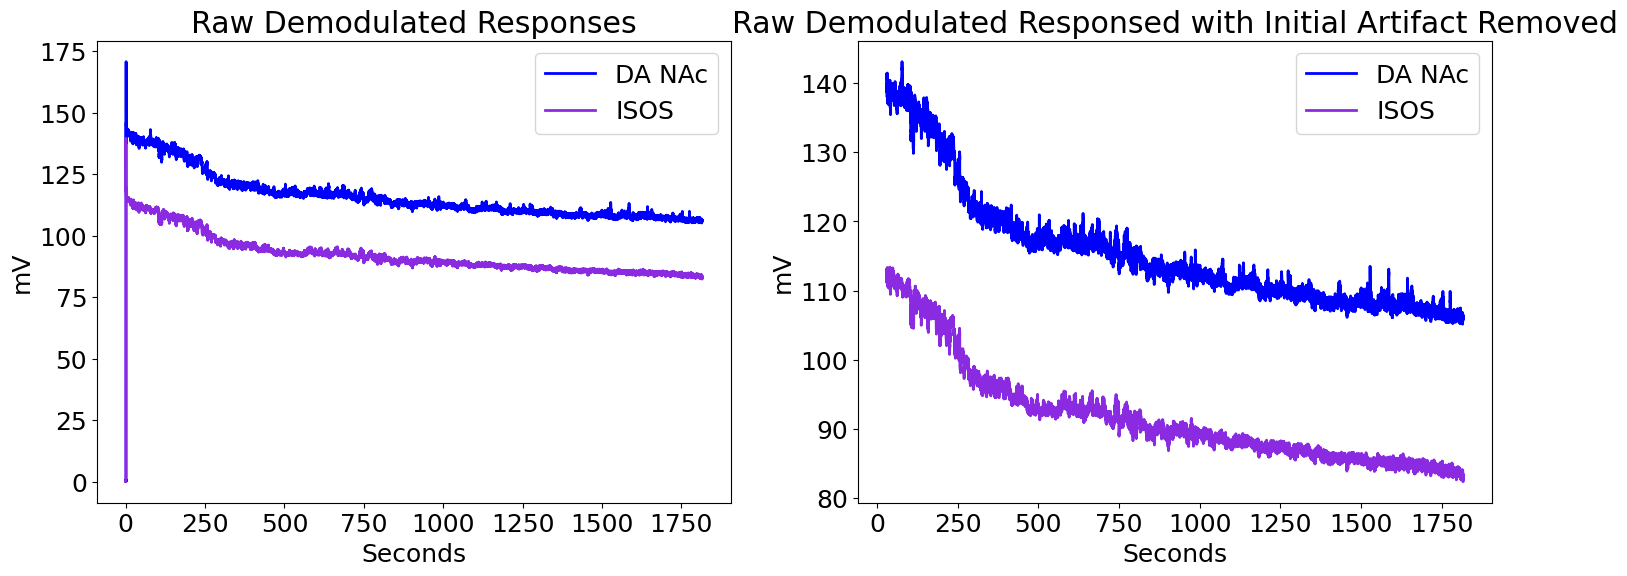

In [57]:
# Make a time array based on the number of samples and sample freq of the demodulated streams
NAc_time = np.linspace(1,len(NAc_data.streams[DA].data), len(NAc_data.streams[DA].data))/NAc_data.streams[DA].fs

# Plot both unprocessed demodulated stream            
fig1 = plt.figure(figsize=(18,6))
ax0 = fig1.add_subplot(121)

# Plotting the traces
p1, = ax0.plot(NAc_time, NAc_data.streams[DA].data, linewidth=2, color='blue', label='DA NAc')
p2, = ax0.plot(NAc_time, NAc_data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')

# There is often a large artifact on the onset of LEDs turning on
# Remove data below a set time t
t = 30
inds = np.where(NAc_time>t)
ind = inds[0][0]
NAc_time = NAc_time[ind:] # go from ind to final index
NAc_data.streams[DA].data = NAc_data.streams[DA].data[ind:]
NAc_data.streams[ISOS].data = NAc_data.streams[ISOS].data[ind:]

# Plot again at new time range
ax1 = fig1.add_subplot(122)

# Plotting the traces
p1, = ax1.plot(NAc_time,NAc_data.streams[DA].data, linewidth=2, color='blue', label='DA NAc')
p2, = ax1.plot(NAc_time,NAc_data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responsed with Initial Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')

## DownSampling

In [58]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []
for i in range(0, len(NAc_data.streams[DA].data), N):
    F465.append(np.mean(NAc_data.streams[DA].data[i:i+N-1])) # This is the moving window mean
NAc_data.streams[DA].data = F465

for i in range(0, len(NAc_data.streams[ISOS].data), N):
    F405.append(np.mean(NAc_data.streams[ISOS].data[i:i+N-1]))
NAc_data.streams[ISOS].data = F405

#decimate time array to match length of demodulated stream
NAc_time = NAc_time[::N] # go from beginning to end of array in steps on N
NAc_time = NAc_time[:len(NAc_data.streams[DA].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# https://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(NAc_data.streams[ISOS].data)
y = np.array(NAc_data.streams[DA].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dFC_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dFC_all, Y_fit_all))
std_dFF = np.std(dFF)

In [59]:
NAc_data.epocs.PC0_.offset

array([  12.9646592 ,   76.64467968,   76.80442368,   77.2145152 ,
         77.31462144,   77.43504384,   77.5446528 ,   77.65458944,
         77.8944512 ,   78.01470976,   78.1246464 ,   78.24457728,
         78.36450816,   78.49459712,   78.62468608,   78.76476928,
         78.905344  ,   79.0347776 ,   79.1846912 ,   79.46452992,
         79.74453248,   79.89477376,   80.04452352,   80.20475904,
         80.36450304,   80.51458048,   80.84455424,   81.17501952,
         81.33443584,   81.49467136,   81.82464512,   81.9945472 ,
         82.15445504,   82.31469056,   82.48475648,   83.30477568,
         83.46468352,   83.60460288,   84.22473728,   84.53455872,
         84.7044608 ,   85.01460992,   85.1746816 ,   85.35457792,
         85.53447424,   85.78465792,   85.93473536,   86.0946432 ,
         86.43444736,   86.71444992,   86.85453312,   87.11471104,
         87.60475648,   88.19474432,   88.28469248,   88.50604032,
         88.7046144 ,   89.24463104,   89.69453568,  110.28463

### Port Entries

In [60]:
Sound_on = NAc_data.epocs.PC3_.onset
Sound_off = NAc_data.epocs.PC3_.offset

Sound_x = np.append(np.append(NAc_time[0], np.reshape(np.kron([Sound_on, Sound_off],
                   np.array([[1], [1]])).T, [1,-1])[0]), NAc_time[-1])
sz = len(Sound_on)
d = NAc_data.epocs.PC3_.data

# Add zeros to beginning and end of 0,1 value array to match len of LICK_x
Sound_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(sz),
    d, d, np.zeros(sz)]).T, [1, -1])[0]),0)

y_scale = 10 #adjust according to data needs
y_shift = -20 #scale and shift are just for aesthetics

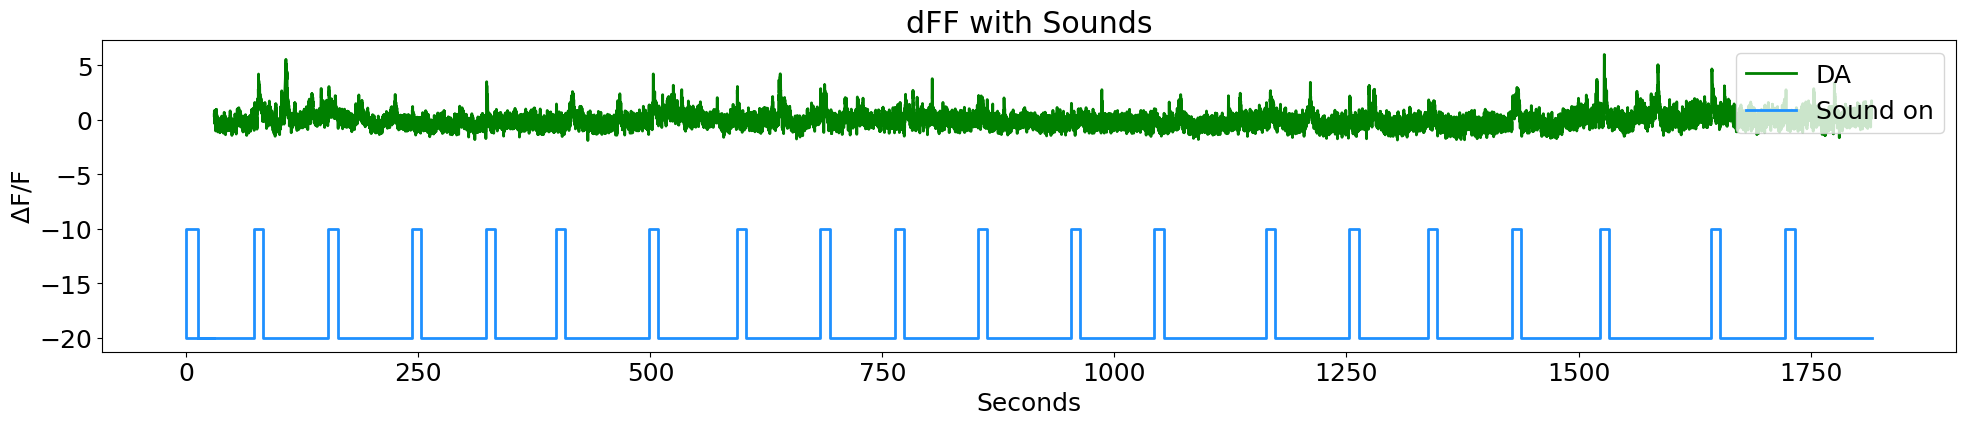

In [61]:
fig2 = plt.figure(figsize=(20,12))
ax3 = fig2.add_subplot(311)
p1, = ax3.plot(NAc_time, dFF, linewidth=2, color='green', label='DA')
p2, = ax3.plot(Sound_x, y_scale*Sound_y+y_shift, linewidth=2, color='dodgerblue', label='Sound on')
ax3.set_ylabel(r'$\Delta$F/F')
ax3.set_xlabel('Seconds')
ax3.set_title('dFF with Sounds')
ax3.legend(handles=[p1, p2], loc='upper right')
fig2.tight_layout()